In [1]:
import warnings
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut
warnings.filterwarnings("ignore")

data = pd.read_csv('/kaggle/input/train/training_data.csv')

# EDA

In [4]:
data.describe()

,PatientID,Resp,VL-t0,CD4-t0
count,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,0.206000,4.29721,279.638000
std,288.819436,0.404633,0.70478,198.186712
min,1.000000,0.000000,2.70000,0.000000
25%,250.750000,0.000000,3.70000,132.750000
50%,500.500000,0.000000,4.30000,249.000000
75%,750.250000,0.000000,4.80000,383.250000
max,1000.000000,1.000000,6.00000,1589.000000


<Axes: >

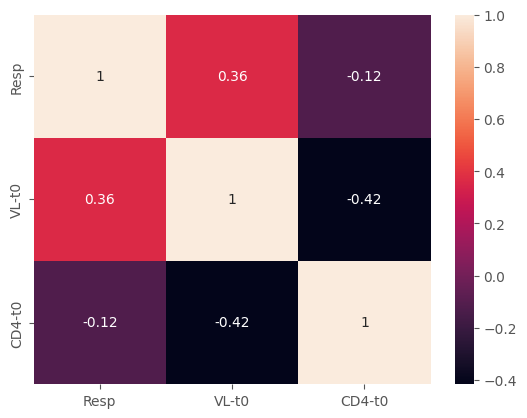

In [628]:
sns.heatmap(data[['Resp','VL-t0','CD4-t0']].corr(), annot=True)

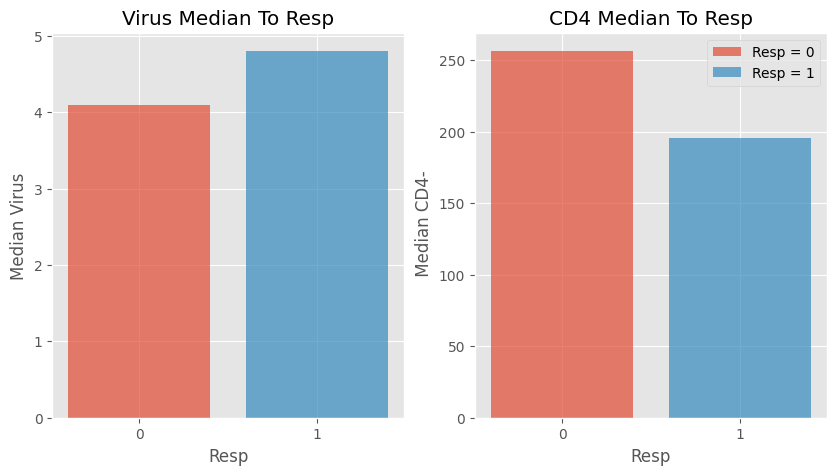

In [629]:
fig , (ax1,ax2) = plt.subplots(1 ,2,figsize=(10,5))

ax1.bar('0' ,data[data['Resp'] == 0]['VL-t0'].median(),label='aaaaesp = 0',alpha=0.7)
ax1.bar('1',data[data['Resp'] == 1]['VL-t0'].median(),label='Resp = 1',alpha=0.7)
ax1.set_ylabel('Median Virus')
ax1.set_xlabel('Resp')
ax1.set_title('Virus Median To Resp')

ax2.bar('0' ,data[data['Resp'] == 0]['CD4-t0'].median(),label='Resp = 0',alpha=0.7)
ax2.bar('1',data[data['Resp'] == 1]['CD4-t0'].median(),label='Resp = 1',alpha=0.7)
ax2.set_ylabel(' Median CD4-')
ax2.set_xlabel('Resp')
ax2.set_title('CD4 Median To Resp')

plt.legend();

# Outlier

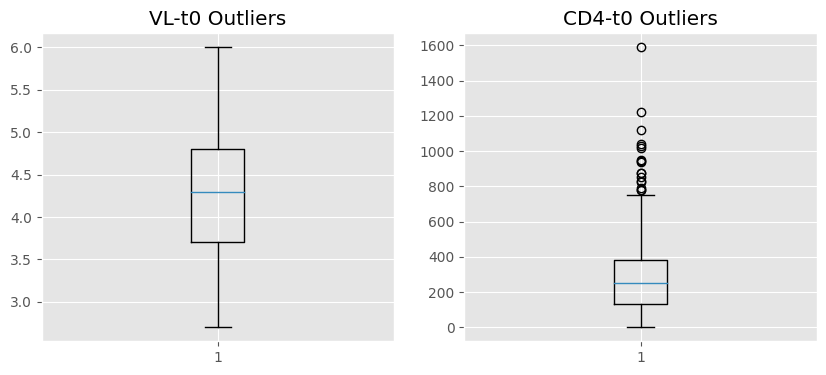

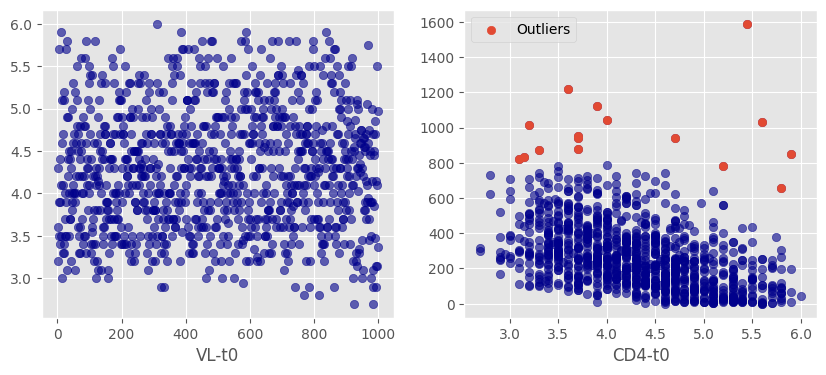

In [630]:
plt.style.use('ggplot')

def Boxplot():
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.boxplot(data['VL-t0'])
    ax2.boxplot(data['CD4-t0'])
    ax1.set_title('VL-t0 Outliers')
    ax2.set_title('CD4-t0 Outliers')

def scatter():
    fig , (ax1,ax2) = plt.subplots(1 ,2,figsize=(10,4))
    flt = (data['CD4-t0'] > 800) | ((data['CD4-t0'] > 650) & (data['VL-t0'] >= 5.2))
    ax2.scatter(data['VL-t0'] ,data['CD4-t0'],c='darkblue' ,alpha=0.6)
    ax2.scatter(data['VL-t0'][flt],data['CD4-t0'][flt],label='Outliers');
    ax1.scatter(list(range(1,1001)) ,data['VL-t0'] ,c='darkblue',label='VL-t0' ,alpha=0.6)
    ax1.set_xlabel('VL-t0')
    ax2.set_xlabel('CD4-t0')
    plt.legend()

    data.drop(data[flt].index ,inplace=True)


Boxplot()

scatter()

# Normalize & Modeling

In [631]:
def Normalization():
    global data,TEST,Norm,X,y

    Norm = MinMaxScaler()

    data = data[['VL-t0','CD4-t0','Resp']]

    data ,TEST = train_test_split(data , test_size=0.3 , random_state=1)

    data = data[['VL-t0','CD4-t0','Resp']]

    X = data.drop('Resp' ,axis=1).values
    y = data['Resp'].values

    X = Norm.fit_transform(X)


Normalization()


def XGBclassifier():

    loo = LeaveOneOut()

    global model,Scores

    Scores = []
    for i, (train, valid) in enumerate(loo.split(X)):
        x_train , y_train = X[train] , y[train]
        x_test , y_test = X[valid] , y[valid]

        model = XGBClassifier(n_estimators=1)
        model.fit(x_train ,y_train)
        Scores.append(model.score(x_test ,y_test))


XGBclassifier()

def LeaveOneOut_Evaluate():

    global y_TEST,Predict
    x_TEST = TEST.drop('Resp' ,axis=1)
    y_TEST = TEST['Resp']

    x_TEST = Norm.transform(x_TEST)
    Predict = model.predict(x_TEST)

    Accuracy = pd.DataFrame(Scores,columns=['Accuracy'])
    print("Accuracy :","%.2f"%(Accuracy.mean()[0] * 100))


LeaveOneOut_Evaluate()

Accuracy : 79.22


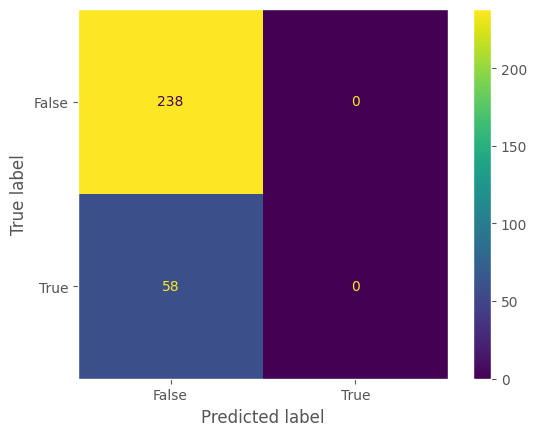

In [632]:
confusion_matrix = metrics.confusion_matrix(y_TEST,Predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False ,True])
cm_display.plot()
plt.grid()